<h1>Analysis of German credit data<h1/>

German credit data is a dataset containing information about debtors. They are classified as good/bad which suggests whether it would be a risk to give them a loan ('good' are those that will likely pay off the loan).   

The dataset comes from the previous century. Therefore, its analysis will not be representative for the present. It may only give as a general overview on which factors are significant when it comes to this kind of scoring.   

The table constists of 21 columns, of which all can potentially influence the scoring. These are variables such as: age of the debtor, civil status (including the information on sex), credit amount, duration, the purpose.  

In my exploratory data analysis I won't analyse all factors, but I will try to determine which factors are important. Moreover, I will look into the difference in loans taken out by men and women.  

Later on I will train different Machine Learning models and try to choose appropriate metrics to evaluate the results.



<h2>Data overview<h2/>

In [68]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

from category_encoders import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, roc_curve, ConfusionMatrixDisplay, roc_auc_score, make_scorer, fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier

In [2]:
#reading the file
df = pd.read_csv('german_credit_data.csv',sep=';')

In [3]:
#cleaning the index
df.reset_index(inplace=True)
df.set_index('index', inplace=True)

In [5]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
index,,,,,,,,,,,,,,,,,,,,,
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


In [6]:
df.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

We see that there are 1000 records in the table. Columns' type varies: there are objects and integers. At first sight, the type matches their content.

In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

Below, we see statistics for columns with numeric values. We may for example see that the average duration of loan is 20 months, and the median is 18 months. The longest duration is 72 months - it may be an outlier, as the value on the 75% percentile is much lower (24 months).   
When it comes to the credit amount, the average is ca. 3200 EUR. There is quite a big difference between the lowest and highest amount (250 vs. 18000).   
The other interesting column is age - the average debtor age is 35.5 years. Here there is also a big difference between the youngest and the oldest (19 vs 75).

In [7]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [8]:
#Checking for nulls
df.isnull().values.any()

False

General check of correlation between numeric variables

In [4]:
labels_x = ['duration','credit_amount','installment_commitment', 'residence_since','age','existing_credits','num_dependents', 'foreign_worker']
correlation_matrix = df[labels_x].corr()
correlation_matrix

/var/folders/9s/y69x5fh17nz2lg8jh5f7t_mm0000gn/T/ipykernel_51242/1344557737.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df[labels_x].corr()


,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
duration,1.000000,0.624984,0.074749,0.034067,-0.036136,-0.011284,-0.023834
credit_amount,0.624984,1.000000,-0.271316,0.028926,0.032716,0.020795,0.017142
installment_commitment,0.074749,-0.271316,1.000000,0.049302,0.058266,0.021669,-0.071207
residence_since,0.034067,0.028926,0.049302,1.000000,0.266419,0.089625,0.042643
age,-0.036136,0.032716,0.058266,0.266419,1.000000,0.149254,0.118201
existing_credits,-0.011284,0.020795,0.021669,0.089625,0.149254,1.000000,0.109667
num_dependents,-0.023834,0.017142,-0.071207,0.042643,0.118201,0.109667,1.000000


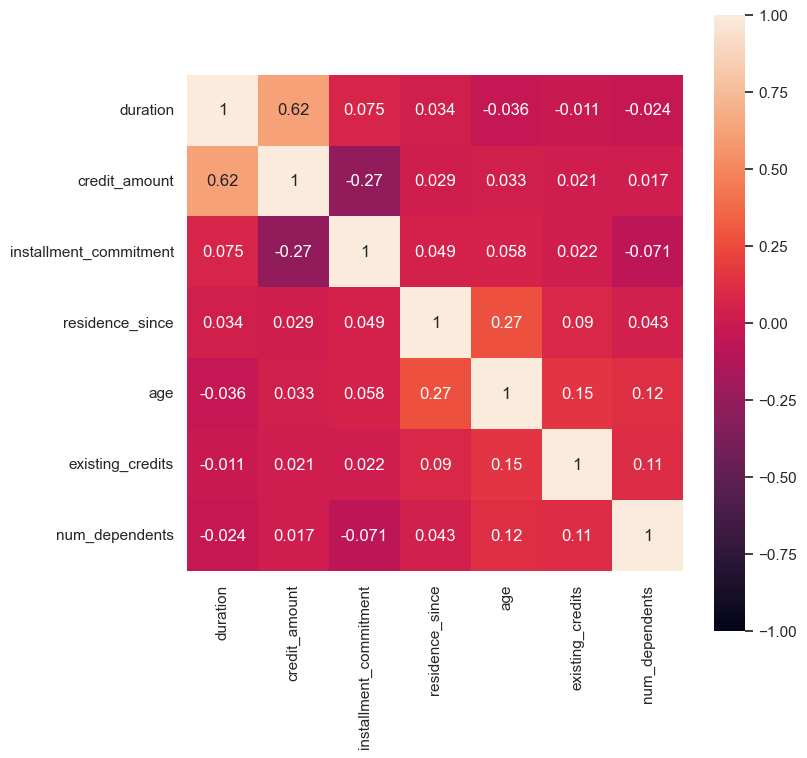

In [5]:
sns.set(rc={'figure.figsize':(8,8)}) 

sns.heatmap(
    correlation_matrix,
    vmin=-1.,
    vmax=1., 
    square=True,
    annot=True) 
pass

There is no strong correlation between any of the variables. The highest correlation is between the duration and the amount. It is not that surprising - it often takes longer to pay off higher loans. This correlation is quite close to the threshold that would classify it as high.

<h2>Exploratory Data Analysis<h2/>

We can see that 700 out of 1000 debtors got the scoring "good" which constitues 70%. The dataset is not well balanced.


In [11]:
df['class'].value_counts()

good    700
bad     300
Name: class, dtype: int64

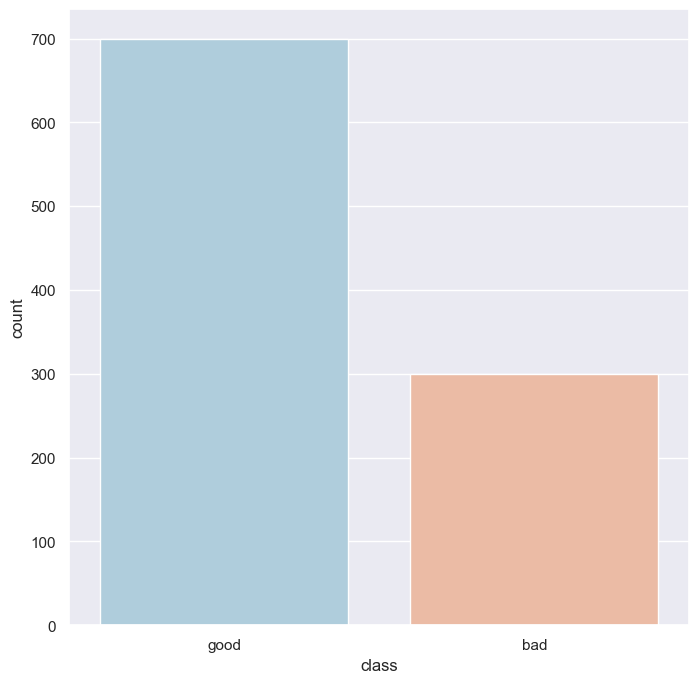

In [12]:
sns.countplot(x='class', data=df, palette='RdBu_r');

<h3>Purpose<h3/>

Let's look into the purpose of loans. What is interesting, there is a predominance of loans for radio/tv (but the most loans were for cars (when we sum up "new car" and "used car")).  
It is probably the result of the fact that the dataset includes relatively small loans.

In [13]:
df['purpose'].unique()

array(['radio/tv', 'education', 'furniture/equipment', 'new car',
       'used car', 'business', 'domestic appliance', 'repairs', 'other',
       'retraining'], dtype=object)

In [14]:
df['purpose'].value_counts().to_frame()

,purpose
radio/tv,280
new car,234
furniture/equipment,181
used car,103
business,97
education,50
repairs,22
domestic appliance,12
other,12
retraining,9


How it looks like considering the scoring?

In [15]:
purpgood = df[df['class']=='good']['purpose'].value_counts().to_frame()
purpbad = df[df['class']=='bad']['purpose'].value_counts().to_frame()


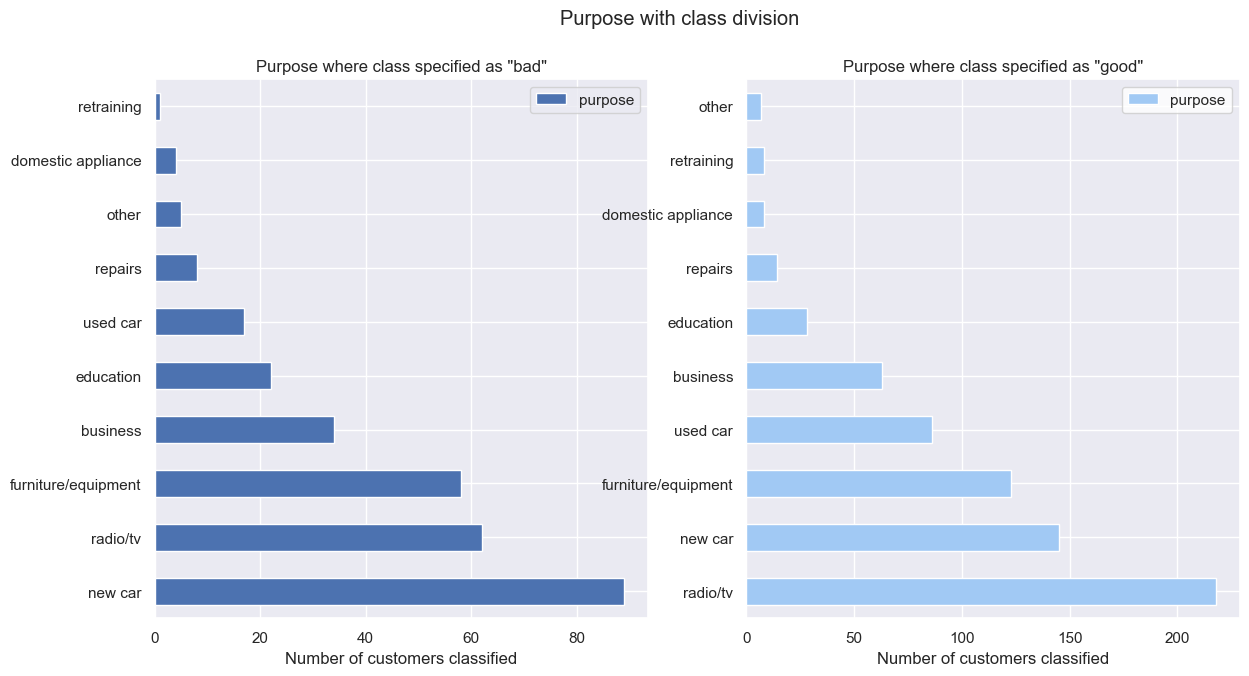

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,7))

purpbad.plot(kind='barh',ax = axes[0], subplots=True)
axes[0].set_title('Purpose where class specified as "bad"')
axes[0].set_xlabel('Number of customers classified')
plt.xlabel('Number of customers classified')
plt.suptitle('Purpose with class division')
sns.set_theme(style="whitegrid", palette="pastel")
purpgood.plot(kind='barh',ax = axes[1], subplots=True)
axes[1].set_title('Purpose where class specified as "good"')
axes[1].set_xlabel('Number of customers classified')

plt.show()

From the bar plots above, we may conclude that loans most considered as risky were car loans - probably because of high amounts. The most people that got a positive scoring wanted to buy a new radio/tv, that is quite cheap things.

<h3>Duration<h3/>

As we can see on the histogram below, most loans were for up to 25 months. Duration does not have a normal distribution, it has almost two modes.

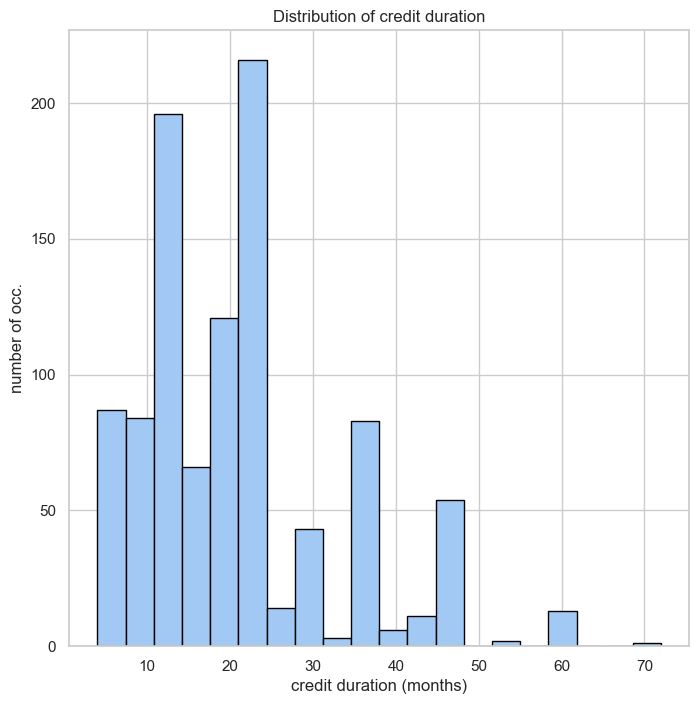

In [21]:
plt.hist(
    df['duration'],
    edgecolor="black",
    bins=20
)
plt.xlabel("credit duration (months)")
plt.ylabel("number of occ.")
plt.title('Distribution of credit duration')
plt.show()

In [22]:
long = df[df['duration']>30]
long['class'].value_counts().to_frame()

,class
good,90
bad,83


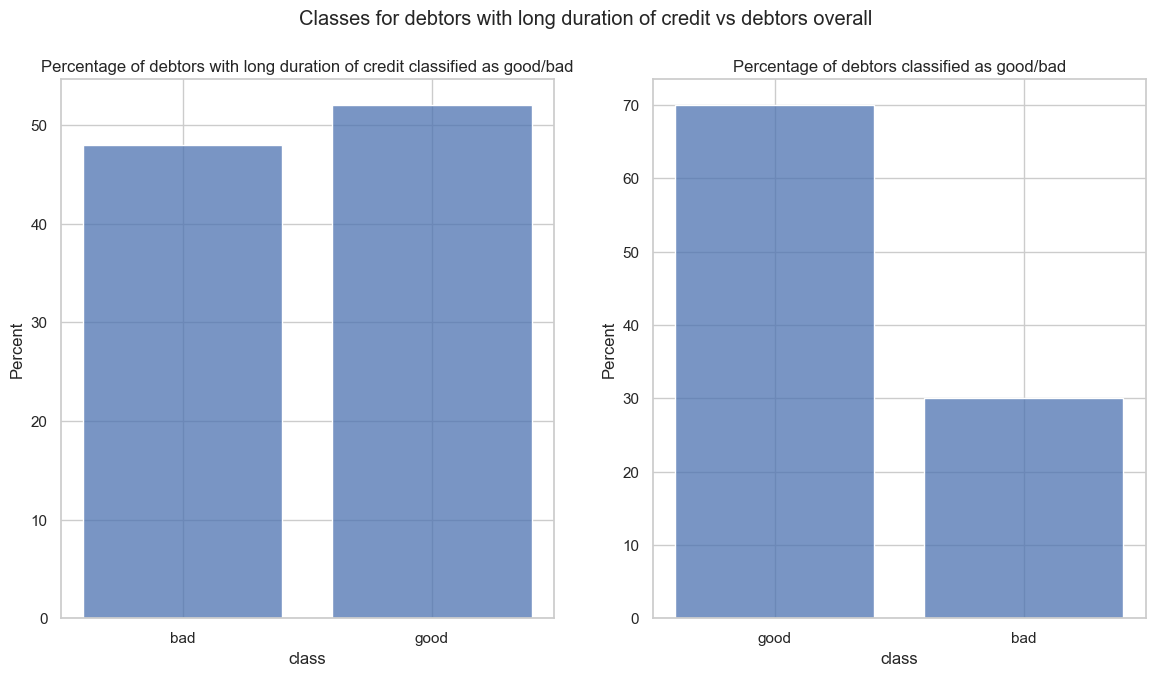

In [24]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors with long duration of credit vs debtors overall')
axes[0].set_title('Percentage of debtors with long duration of credit classified as good/bad')
sns.histplot(x='class', data=long, stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Percentage of debtors classified as good/bad')
sns.histplot(x='class', data=df, stat='percent', shrink=0.8, ax=axes[1])

plt.show()

As we see on plots above, for people who wanted to take out a loan for a period over 30 months, scorings are almost even, which is far from the average. Almost 50% of debtors from this category were classified as "bad". It suggests that the duration has a big influence on the scoring.

<h2>Credit amount<h2/>

In [50]:
expens = df[df['credit_amount']>5000]
expens['class'].value_counts().to_frame()

,class
good,110
bad,78


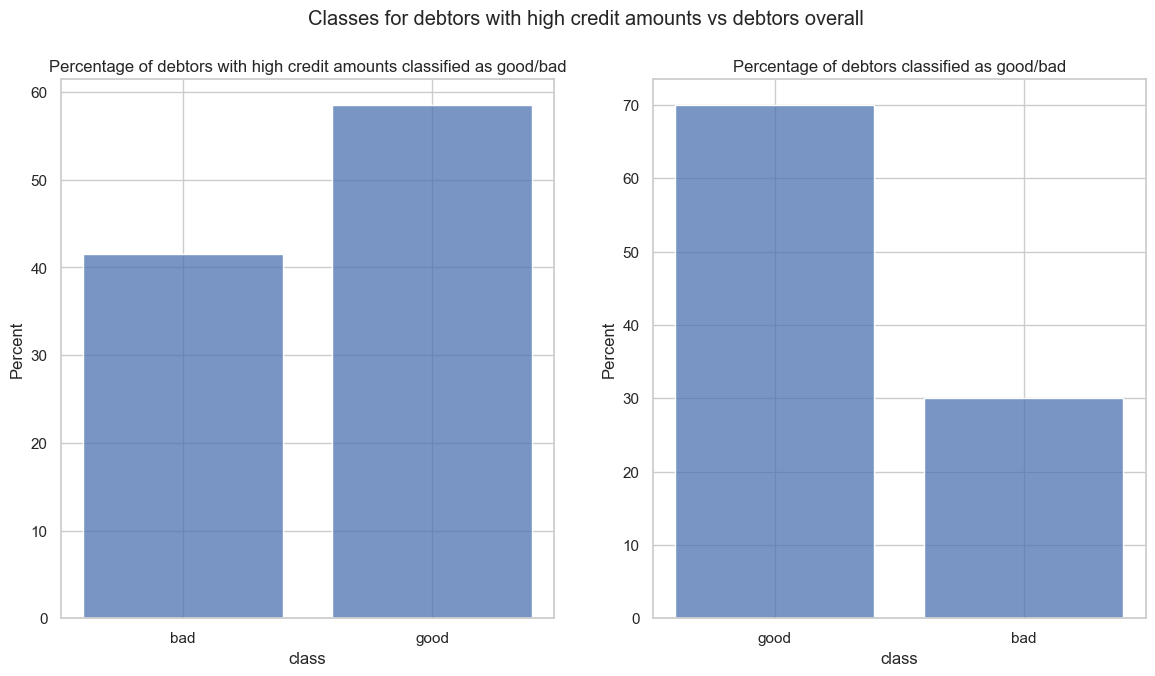

In [51]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors with high credit amounts vs debtors overall')
axes[0].set_title('Percentage of debtors with high credit amounts classified as good/bad')
sns.histplot(x='class', data=expens, stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Percentage of debtors classified as good/bad')
sns.histplot(x='class', data=df, stat='percent', shrink=0.8, ax=axes[1])
plt.show()

As we can see on the plots above, credit amount did also influence the scoring. For those who wanted to take out a loan for over 5,000 euros, the scoring is much less favourable (difference by over 10 percent points).

<h3>Housing<h3/>

Does it matter whether a debtor has his/her own realty?

In [25]:
df.housing.value_counts().to_frame()

,housing
own,713
rent,179
for free,108


In [26]:
hasown = df[df['housing']=='own']
hasown['class'].value_counts().to_frame()

,class
good,527
bad,186


As we see on the plots below, owning a property doesn't have a very big influence on the scoring - it's a difference by only a few percent points.

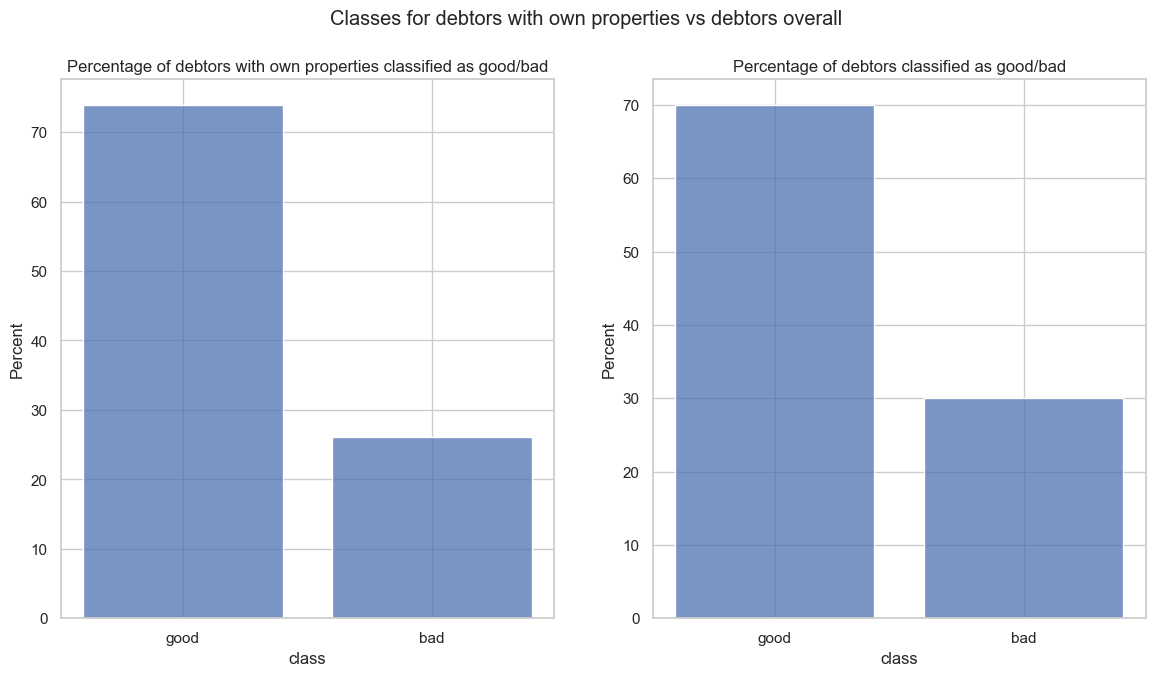

In [29]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors with own properties vs debtors overall')
axes[0].set_title('Percentage of debtors with own properties classified as good/bad')
sns.histplot(x='class', data=hasown, stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Percentage of debtors classified as good/bad')
sns.histplot(x='class', data=df, stat='percent', shrink=0.8, ax=axes[1])

plt.show()

<h3>Employment<h3/>

From the dataset we may also learn whether debtors are qualified employees or unemployed. It seems to be a piece of information that should really influence the scoring.

In [30]:
df.job.value_counts().to_frame()

,job
skilled,630
unskilled resident,200
high qualif/self emp/mgmt,148
unemp/unskilled non res,22


Qualified and highly qualified debtors, divided by scoring:

In [31]:
qualjob = df[(df['job']=='skilled') | (df['job']=='high qualif/self emp/mgmt')]
qualjob['class'].value_counts().to_frame()


,class
good,541
bad,237


Unqualified/unemployed divided by scoring:

In [33]:
nonqual = df[(df['job']=='unskilled resident') | (df['job']=='unemp/unskilled non res')]
nonqual['class'].value_counts().to_frame()

,class
good,159
bad,63


The difference is very insignificant - it almost doesn't matter whether a person is qualified.

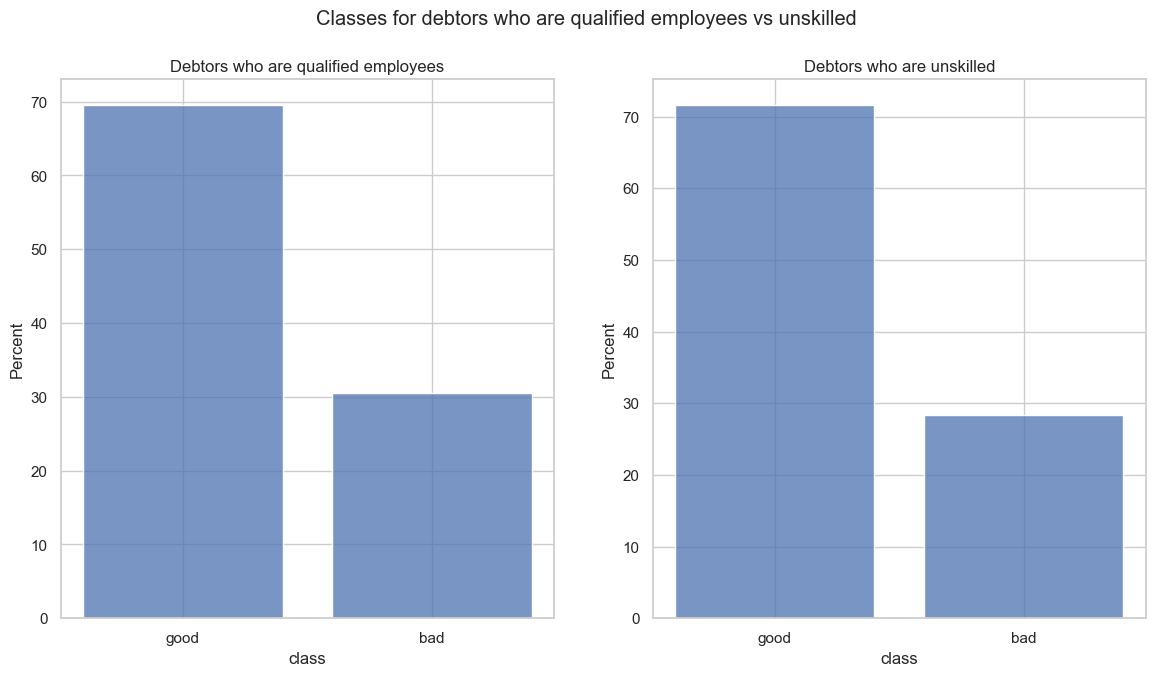

In [34]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors who are qualified employees vs unskilled')
axes[0].set_title('Debtors who are qualified employees')
sns.histplot(x='class', data=qualjob, stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Debtors who are unskilled')
sns.histplot(x='class', data=nonqual, stat='percent', shrink=0.8, ax=axes[1])
plt.show()

When we consider only unemployed, are they classified differently?

In [37]:
df[df['employment']=='unemployed']['class'].value_counts().to_frame()

,class
good,39
bad,23


In [35]:
nowork = df[df['employment']=='unemployed']


Considering the unemployed, there is a slightly bigger difference comparing to the entire dataset. Almost 40% of unemployed were scored as "bad" (it's 30% for all debtors).

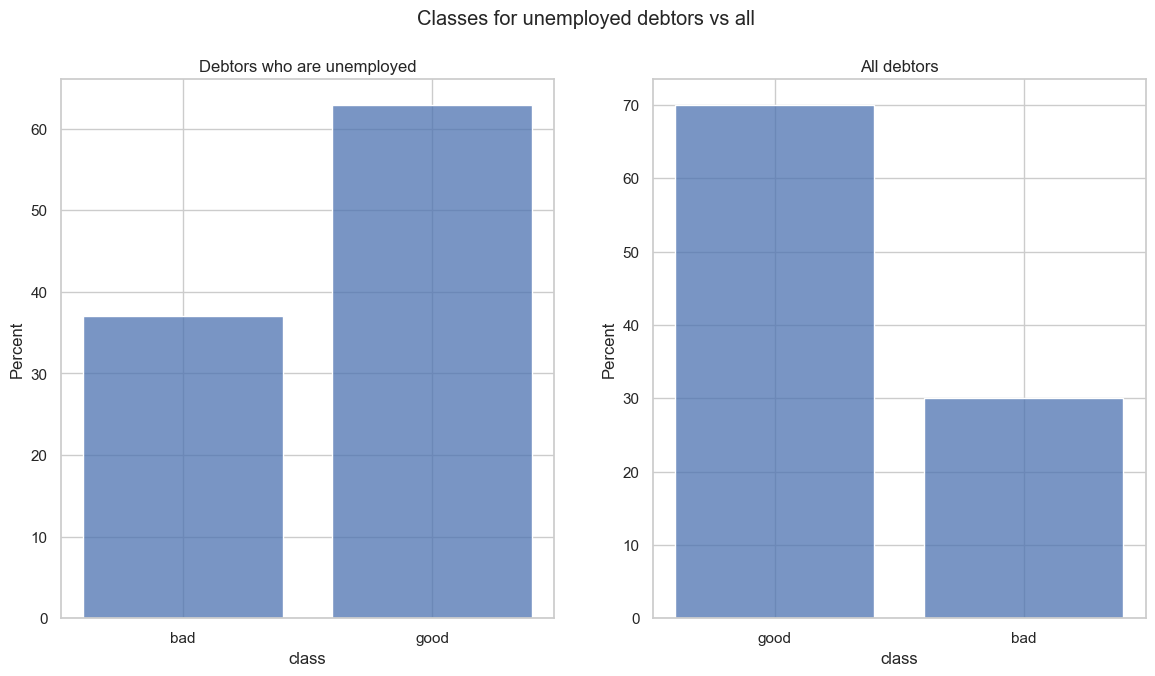

In [36]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for unemployed debtors vs all')
axes[0].set_title('Debtors who are unemployed')
sns.histplot(x='class', data=nowork, stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('All debtors')
sns.histplot(x='class', data=df, stat='percent', shrink=0.8, ax=axes[1])
plt.show()

The column which gives us an interesting overview on the whole dataset, is "foreign worker". It turns out that almost all records regard foreign workers, not Germans.

In [38]:
df['foreign_worker'].value_counts().to_frame()

,foreign_worker
yes,963
no,37


That's why, when we filter only people classified as "foreign workers", that is the majority of records and results of the scoring are representative for the entire dataset.

In [39]:
df[df['foreign_worker']=='yes']['class'].value_counts().to_frame()

,class
good,667
bad,296


It's quite different when we filter those that are NOT foreign workers. The majority has the "good" scoring.

In [40]:
df[df['foreign_worker']=='no']['class'].value_counts().to_frame()

,class
good,33
bad,4


<h3>Analysis considering the sex<h3/>

The fact that sex is included in the personal status enables us to analyse what kind of debtors are men and women. We should remember that the dataset is quite old, so the fact that there are more men than women should not amaze us, because women were much less financially independent in the previous century than they are now.

In [41]:
df['personal_status'].unique()

array(['male single', 'female div/dep/mar', 'male div/sep',
       'male mar/wid'], dtype=object)

It's interesting that the only women that took out loans were married/divorced. In case of men, we have a much bigger range of labels, including singles.

In [ ]:
female = df[df['personal_status'].str.contains('female')]
male = df[~df['personal_status'].str.contains('fe')]

In [43]:
sexc = pd.DataFrame({
    'sex': ['female','male'],
    'count': [len(female), len(male)]
})

In [44]:
sexc

,sex,count
0,female,310
1,male,690


According to expectations, there are over twice as many men as women.

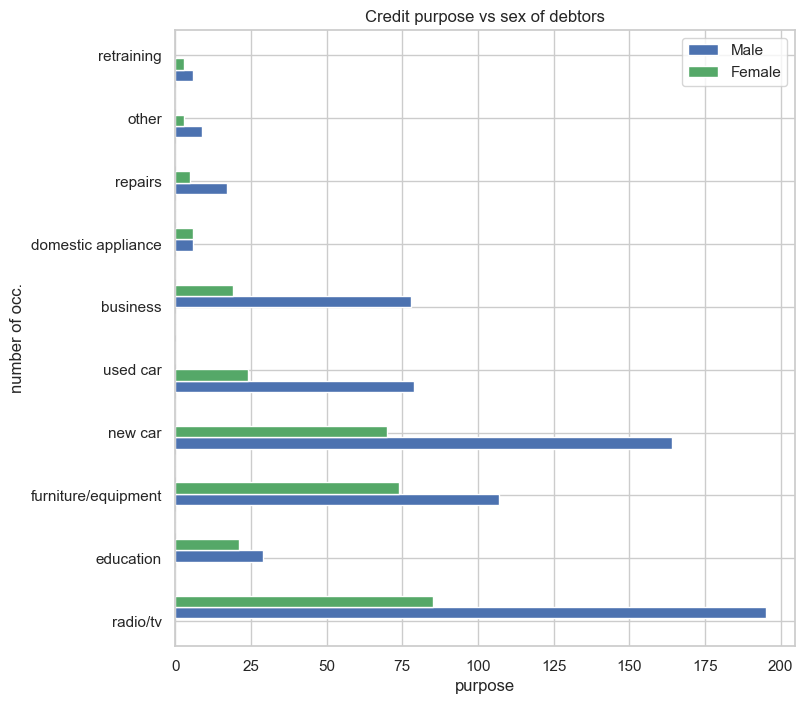

In [46]:
plt.hist(
    [male['purpose'], female['purpose']],
    bins=20,
    orientation='horizontal'
)
plt.xlabel("purpose")
plt.ylabel("number of occ.")
plt.legend(['Male','Female'],loc='upper right')
plt.title('Credit purpose vs sex of debtors')
plt.show()

For both men and women it was the most common to take out loans for radio/tv. What's interesting, for women the second most often purpose was furniture/equipment, and for men a new car.

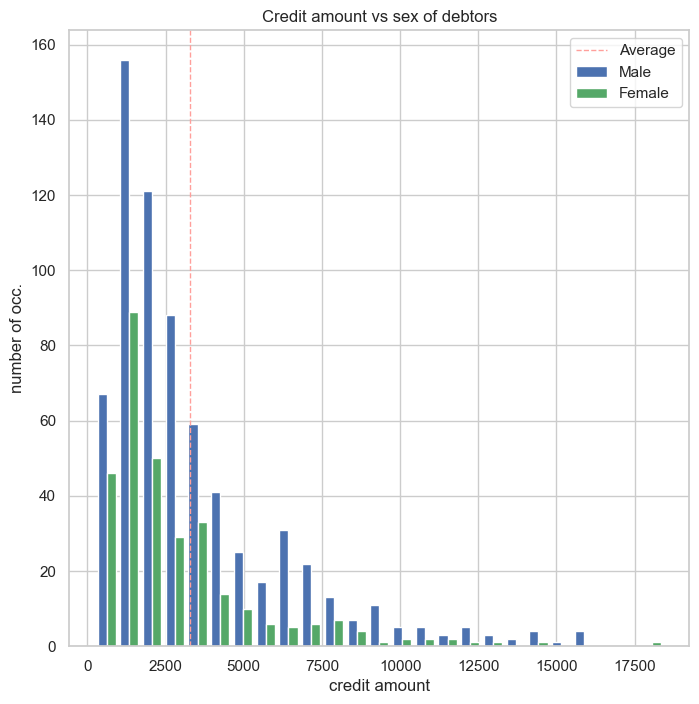

In [47]:
plt.hist(
    [male['credit_amount'], female['credit_amount']],
    bins=25,
)
plt.xlabel("credit amount")
plt.axvline(df['credit_amount'].mean(), color='r', linestyle='dashed',linewidth=1, label='Average')
plt.ylabel("number of occ.")
plt.legend(['Average','Male','Female'],loc='upper right')
plt.title('Credit amount vs sex of debtors')
plt.show()

As we can see on the above histogram (that has one mode and is right-skewed), there is not a lot of credits for high amounts. What's interesting is that the loan for over 17,000 euros was taken out by a woman.

How does the classification of women and men with regards to the scoring look like?

In [52]:
femclass = pd.pivot_table(female,index='class',values='purpose', aggfunc=len)
femclass.reset_index(inplace=True)
femclass = femclass.rename(columns={'purpose':'female'})


In [53]:
maleclass = pd.pivot_table(male,index='class',values='purpose', aggfunc=len)
maleclass.reset_index(inplace=True)
maleclass = maleclass.rename(columns={'purpose':'male'})


As we see in the table below, percentage-wise, more women got the "bad" scoring. The difference is quite significant - by almost 8 percent points.

In [54]:
totalclass = femclass.merge(maleclass, how='outer', on = 'class')

totalclass['female %'] = totalclass['female'] / totalclass['female'].sum()*100
totalclass['male %'] = totalclass['male'] / totalclass['male'].sum()*100
totalclass = totalclass.round(2)
totalclass


,class,female,male,female %,male %
0,bad,109,191,35.16,27.68
1,good,201,499,64.84,72.32


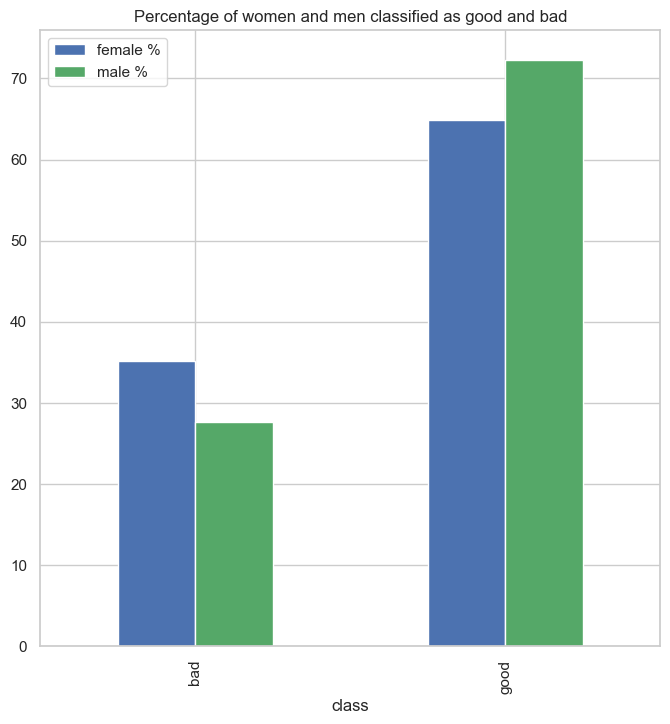

In [55]:
toplot = totalclass.drop(['female','male'], axis=1)
toplot.plot(kind='bar',x='class')
plt.title('Percentage of women and men classified as good and bad')
plt.show()

<h2>Age<h2/>

Considering the age of debtors, there are no significant differences between women and men. It may be worth noticing that the highest concentration of records is around 30 years old.

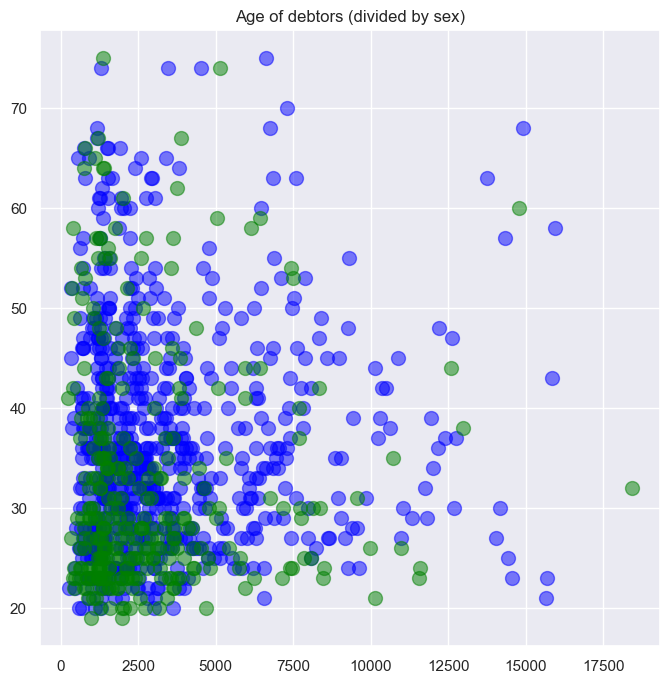

In [235]:
plt.scatter(male['credit_amount'], male['age'], s=100, color='blue', alpha=0.5)
plt.scatter(female['credit_amount'], female['age'], s=100, color='green', alpha=0.5)
plt.title('Age of debtors (divided by sex)')
plt.show()

In [56]:
young = df[df['age']<30]
young['class'].value_counts().to_frame()

,class
good,234
bad,137


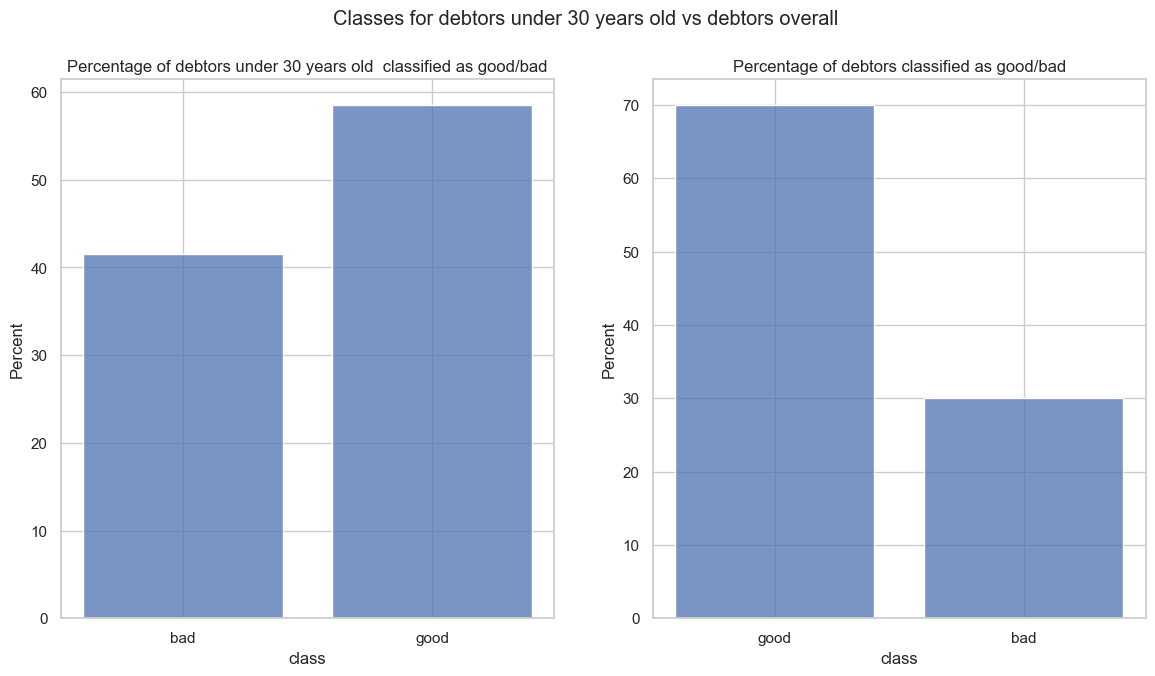

In [57]:
fig, axes = plt.subplots(nrows=1 , ncols=2, figsize=(14,7))
plt.suptitle('Classes for debtors under 30 years old vs debtors overall')
axes[0].set_title('Percentage of debtors under 30 years old  classified as good/bad')
sns.histplot(x='class', data=expens, stat='percent', shrink=0.8, ax=axes[0])
axes[1].set_title('Percentage of debtors classified as good/bad')
sns.histplot(x='class', data=df, stat='percent', shrink=0.8, ax=axes[1])
plt.show()

Based on the above plots, we may conclude that age has an influence on scoring - people under 30 years old were more often classified as "bad".

In general, we see that many factors influence our target variable (scoring). Among the most important ones, there are: credit amount, duration, sex and age.

<h3>Data preparation - feature engineering<h3/>

First I will check which columns are numerical, and which are categorical. It will give me an insight into which columns need to be transformed before they are fed to the model.

In [6]:
num_list = []
for column in df.columns:
    if column in df.select_dtypes(np.number).columns:
        num_list.append(column)
num_list

['duration',
 'credit_amount',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'num_dependents']

In [7]:
list_cat = []
for column in list(df.columns):
    if column not in num_list:
        list_cat.append(column)
list_cat

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'personal_status',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'foreign_worker',
 'class']

We can see that there is a majority of categorical columns. 

In [8]:
#creating the label encoder
labelencoder = LabelEncoder()

In [9]:
#first I'm transforming the "obvious" columns, so those that had yes/no labels
df['class'] = labelencoder.fit_transform(df['class'])
df['foreign_worker'] = labelencoder.fit_transform(df['foreign_worker'])
df['own_telephone'] = labelencoder.fit_transform(df['own_telephone'])

I want to transform as many columns as possible in a way that acummulates labels in single columns (to avoid creating multiple columns for single categories). Thanks to that they will be lighter for the model in terms of calculations. I'm transforming the columns, where serial order is logical (for example savings, checking status, employment). I'm using the Ordinal Encoder that enables mapping values into numerical values.

In [13]:
maplist = [{'col' : 'checking_status', 
            'mapping': 
            {
                'no checking':0,
                '<0':1,
                '0<=X<200':2,
                '>=200':3
            }
},
{'col' : 'savings_status',
 'mapping':
 {
     'no known savings':0,
     '<100':1,
     '100<=X<500':2,
     '500<=X<1000':3,
     '>=1000':4
 }
},
{'col' : 'employment',
 'mapping':
 {
    'unemployed':0,
    '<1':1,
    '1<=X<4':2,
    '4<=X<7':3,
    '>=7':4
 }   
},
{
    'col' : 'job',
    'mapping':
    {
        'unemp/unskilled non res':0,
        'unskilled resident':1,
        'skilled':2,
        'high qualif/self emp/mgmt':3
    }
}
]
oe = OrdinalEncoder(mapping=maplist)
df = oe.fit_transform(df)

I initialize lists with numerical and categorical columns once again, let's see what has changed.

In [15]:
num_list = []
for column in df.columns:
    if column in df.select_dtypes(np.number).columns:
        num_list.append(column)
num_list

['checking_status',
 'duration',
 'credit_amount',
 'savings_status',
 'employment',
 'installment_commitment',
 'residence_since',
 'age',
 'existing_credits',
 'job',
 'num_dependents',
 'own_telephone',
 'foreign_worker',
 'class']

In [16]:
list_cat = []
for column in list(df.columns):
    if column not in num_list:
        list_cat.append(column)
list_cat

['credit_history',
 'purpose',
 'personal_status',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing']

I will transform the rest of categorical columns with pandas get_dummies - each label will get its own column. It makes the data more complex, but not in a very strong way, as I have transformed the rest of the columns in a different way before

In [17]:
df = pd.get_dummies(data=df, columns=list_cat, drop_first=True)
df

,checking_status,duration,credit_amount,savings_status,employment,installment_commitment,residence_since,age,existing_credits,job,...,personal_status_male single,other_parties_guarantor,other_parties_none,property_magnitude_life insurance,property_magnitude_no known property,property_magnitude_real estate,other_payment_plans_none,other_payment_plans_stores,housing_own,housing_rent
index,,,,,,,,,,,,,,,,,,,,,
0,1,6,1169,0,4,4,4,67,2,2,...,1,0,1,0,0,1,1,0,1,0
1,2,48,5951,1,2,2,2,22,1,2,...,0,0,1,0,0,1,1,0,1,0
2,0,12,2096,1,3,2,3,49,1,1,...,1,0,1,0,0,1,1,0,1,0
3,1,42,7882,1,3,2,4,45,1,2,...,1,1,0,1,0,0,1,0,0,0
4,1,24,4870,1,2,3,4,53,2,2,...,1,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,12,1736,1,3,3,4,31,1,1,...,0,0,1,0,0,1,1,0,1,0
996,1,30,3857,1,2,4,4,40,1,3,...,0,0,1,1,0,0,1,0,1,0
997,0,12,804,1,4,4,4,38,1,2,...,1,0,1,0,0,0,1,0,1,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                                         Non-Null Count  Dtype
---  ------                                         --------------  -----
 0   checking_status                                1000 non-null   int64
 1   duration                                       1000 non-null   int64
 2   credit_amount                                  1000 non-null   int64
 3   savings_status                                 1000 non-null   int64
 4   employment                                     1000 non-null   int64
 5   installment_commitment                         1000 non-null   int64
 6   residence_since                                1000 non-null   int64
 7   age                                            1000 non-null   int64
 8   existing_credits                               1000 non-null   int64
 9   job                                            1000 non-null   int64
 10  n

In [20]:
#type transformation
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                                         Non-Null Count  Dtype
---  ------                                         --------------  -----
 0   checking_status                                1000 non-null   int64
 1   duration                                       1000 non-null   int64
 2   credit_amount                                  1000 non-null   int64
 3   savings_status                                 1000 non-null   int64
 4   employment                                     1000 non-null   int64
 5   installment_commitment                         1000 non-null   int64
 6   residence_since                                1000 non-null   int64
 7   age                                            1000 non-null   int64
 8   existing_credits                               1000 non-null   int64
 9   job                                            1000 non-null   int64
 10  n

<h2>Choosing the right metrics<h2/>

The dataset is not balanced well, that's why choosing accuracy which is the default metric for classification problems, is not a good idea. It will be more valuable to look into f-beta score.   
   
The business aim will be here to minimize losses for the enterprise and be as precise as possible with our prediction. We will try to predict whether a person will pay of his/her liability. We will try to minimize false positive predictions. Debtors classified as "good" that will in fact not pay off the loan, are a great cost for the enterprise. My main metric will be f-beta score. It calculates the harmonic mean between precision and recall. F-beta has an advantage over f-1 score when we have poorly balanced data, because using the parameter beta, we may specify whether precision or recall is more important for us. Because I want to minimize false positives, I will set beta to 0.5 - precision will have a higher weight. 

<h2>Splitting the dataset<h2/>

In [73]:
#initialization of the random_state that will be used later on
random_state = 123
#black list for columns that are not to be included in X - here it is our target variable
black_list = ['class']

y = df[black_list]
features = [x for x in list(df.columns) if x not in black_list]
X = df[features]

In [23]:
#splitting the dataset - I'm using stratify so that the balance of classes is similar on test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)

In [61]:
train_class = y_train.value_counts().to_frame('number')
test_class = y_test.value_counts().to_frame('number')
train_class.reset_index(inplace=True)
test_class.reset_index(inplace=True)

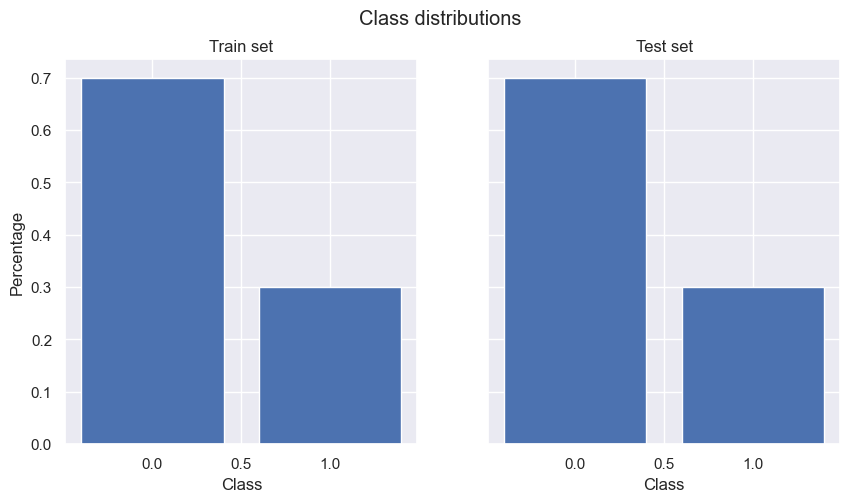

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax1.bar(train_class.index, train_class['number']/sum(train_class['number']))
ax2.bar(test_class.index, test_class['number']/sum(test_class['number']))
plt.suptitle('Class distributions')
ax1.set_title('Train set')
ax2.set_title('Test set')
ax1.set_xlabel('Class')
ax2.set_xlabel('Class')
ax1.set_ylabel('Percentage')
plt.show()

As we can see above, there is the same balance of classes on train and test.

<h2>Defining simple models<h2/>

Defining Stratified validation - we want to minimize the affect of the fact that classes are imbalanced. 

In [66]:
skf_val = StratifiedKFold(shuffle=True, random_state=random_state)

In [69]:
dummy = DummyClassifier(strategy='stratified')
lr = LogisticRegression(random_state=random_state, max_iter=1000)
dt = DecisionTreeClassifier(random_state=random_state)
rf = RandomForestClassifier(random_state=random_state)
xgb = XGBClassifier(eval_metric='error', random_state=random_state)
knn = KNeighborsClassifier()
svm = SVC(random_state=random_state)

models = [dummy, lr, dt, rf, xgb, knn, svm]

In [70]:
def modelling(model, X, y, cv):
    """
            model - model for which we will calculate accuracy and f-beta score
            X - input
            y - target variable
            cv - crossvalidation
    An easy function that calculates f-beta score and accuracy for given models. Crossvalidation is applied to minimize overfitting 
    and to address the issue of imbalanced classes. Time is also calculated.
    """
    model_name = type(model).__name__

    fbeta_scorer = make_scorer(fbeta_score, beta=0.5)

    start = time()
    fbeta_result = cross_val_score(model, X, y, cv=cv, scoring=fbeta_scorer)
    acc_result = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    end = time()
    cv_time = end - start

    print(f"{model_name} \n fbeta: {np.mean(fbeta_result)} \n accuracy:{np.mean(acc_result)} \n time: {cv_time}")



In [74]:
for model in models:
    modelling(model, X_train, y_train.values.ravel(), skf_val)

DummyClassifier 
 fbeta: 0.7125265653689435 
 accuracy:0.57 
 time: 0.03555488586425781
LogisticRegression 
 fbeta: 0.7821732097904535 
 accuracy:0.7214285714285714 
 time: 1.0056300163269043
DecisionTreeClassifier 
 fbeta: 0.7549601502085054 
 accuracy:0.65 
 time: 0.0670919418334961
RandomForestClassifier 
 fbeta: 0.801895990982765 
 accuracy:0.7557142857142857 
 time: 1.8825511932373047
XGBClassifier 
 fbeta: 0.8028223823465901 
 accuracy:0.7371428571428572 
 time: 1.3618288040161133
KNeighborsClassifier 
 fbeta: 0.7237160918549724 
 accuracy:0.63 
 time: 0.13048410415649414
SVC 
 fbeta: 0.7535417635226003 
 accuracy:0.7114285714285715 
 time: 0.3266429901123047


In this case, the best models are XGBoost and Random Forest. Random Forest has slightly higher accuracy, bot longer time and slightly lower f-beta.

In [76]:
# fitting models
for model in models:
    model.fit(X_train, y_train.values.ravel())

In [77]:
#prediction
y_pred_dm = dummy.predict(X_test)
y_pred_lr = lr.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_svm = svm.predict(X_test)

In [78]:
fbeta_dummy = fbeta_score(y_test, y_pred_dm, beta=0.5)
fbeta_lr = fbeta_score(y_test, y_pred_lr, beta=0.5)
fbeta_dt = fbeta_score(y_test, y_pred_dt, beta=0.5)
fbeta_rf = fbeta_score(y_test, y_pred_rf, beta=0.5)
fbeta_xgb = fbeta_score(y_test, y_pred_xgb, beta=0.5)
fbeta_knn = fbeta_score(y_test, y_pred_knn, beta=0.5)
fbeta_svm = fbeta_score(y_test, y_pred_svm, beta=0.5)

print(f'Dummy f-beta {fbeta_dummy}')
print(f"Logistic Regression f-beta {fbeta_lr}")
print(f"Decision Tree f-beta {fbeta_dt}")
print(f"Random Forest f-beta {fbeta_rf}")
print(f"XGBoost f-beta {fbeta_xgb}")
print(f"KNN f-beta {fbeta_knn}")
print(f"SVM f-beta {fbeta_svm}")

Dummy f-beta 0.6990291262135921
Logistic Regression f-beta 0.7804674457429048
Decision Tree f-beta 0.7984031936127746
Random Forest f-beta 0.7886178861788617
XGBoost f-beta 0.8180987202925045
KNN f-beta 0.7504078303425774
SVM f-beta 0.7532751091703057


Checking predictions on the test set has made XGBoosts supremacy more visible. Difference between XGBoost and the next tree model (Decision Tree) is ca. 1.5 percent points.  
Other metrics will be checked only on tree models, that perform much better than logistic regression, KNN and SVM.

<h2>Confusion matrix for tree models<h2/>

For XGBoost:

              precision    recall  f1-score   support

           0       0.61      0.53      0.57        90
           1       0.81      0.85      0.83       210

    accuracy                           0.76       300
   macro avg       0.71      0.69      0.70       300
weighted avg       0.75      0.76      0.75       300



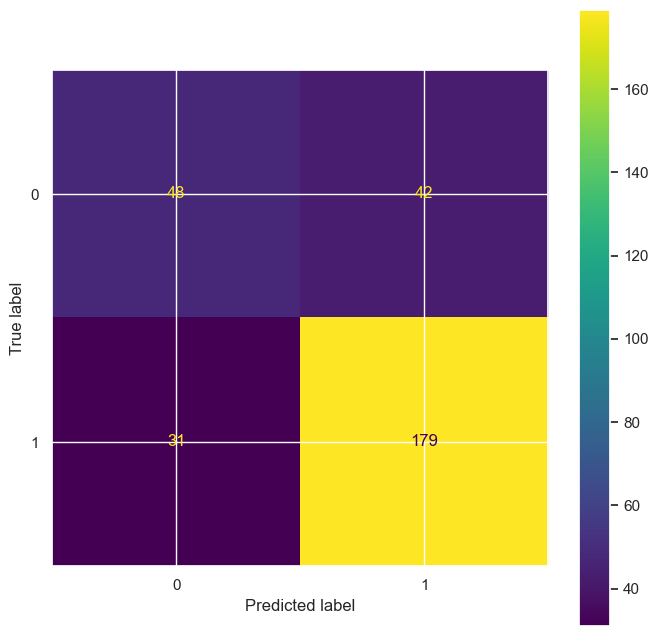

In [79]:
cm = confusion_matrix(y_test, y_pred_xgb)
cm_display = ConfusionMatrixDisplay(cm).plot()

print(classification_report(y_test, y_pred_xgb))

We see that 42 people specified as "good" should be actually classified as "bad". The model performs much better in predicting the class that has more records.

For Random Forest:

              precision    recall  f1-score   support

           0       0.64      0.32      0.43        90
           1       0.76      0.92      0.83       210

    accuracy                           0.74       300
   macro avg       0.70      0.62      0.63       300
weighted avg       0.73      0.74      0.71       300



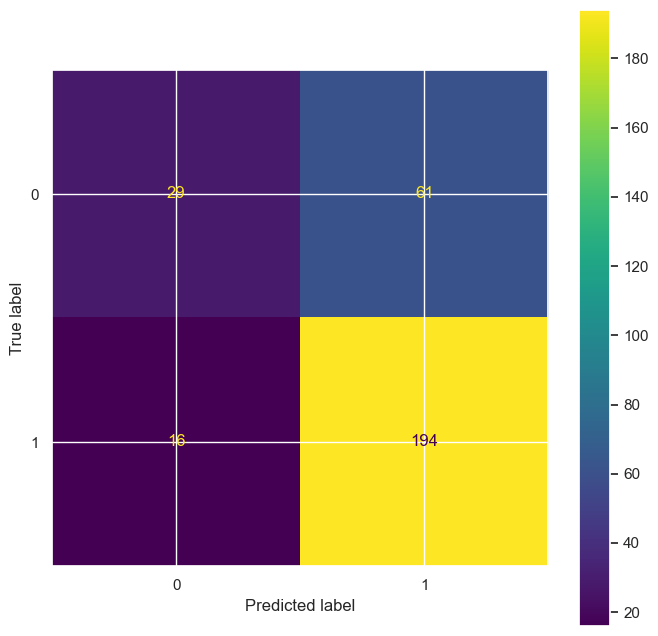

In [80]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_display = ConfusionMatrixDisplay(cm).plot()

print(classification_report(y_test, y_pred_rf))

Here the situation is quite similar, but this model performs better in predicting the "good" class, much worse in predicting "bad" - here contitute 61 people a potential loss for the enterprise.

For Decision Tree:

              precision    recall  f1-score   support

           0       0.51      0.58      0.54        90
           1       0.81      0.76      0.78       210

    accuracy                           0.71       300
   macro avg       0.66      0.67      0.66       300
weighted avg       0.72      0.71      0.71       300



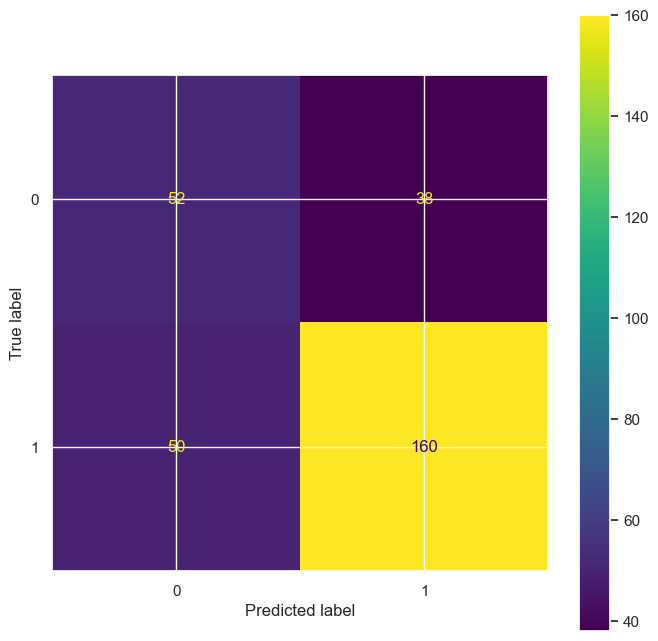

In [81]:
cm = confusion_matrix(y_test, y_pred_dt)
cm_display = ConfusionMatrixDisplay(cm).plot()

print(classification_report(y_test, y_pred_dt))

In case of Decision Tree, we have a much better traceability of the "bad" class than it was the case for Random Forest. Results are close to those of XGBoost.

<h2>Precision-Recall curve<h2/>

I decided to check Precision-Recall curve for tree models. This curve has an advantage over ROC-AUC in cases of imbalanced data.   
Precision-Recall curve is a plot of precision and recall for different thresholds. As for ROC, it's most reasonable to calculate the area under the curve, which tells us about the quality of our predictions.

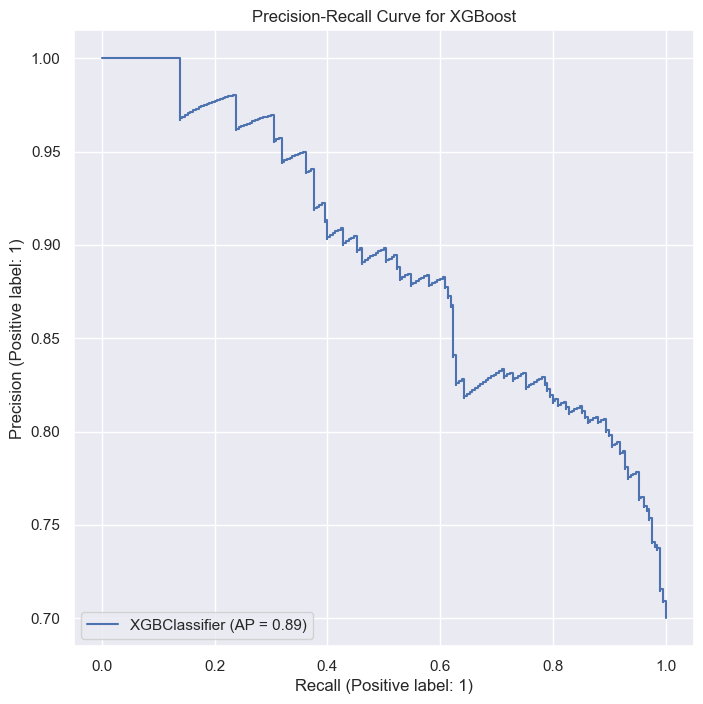

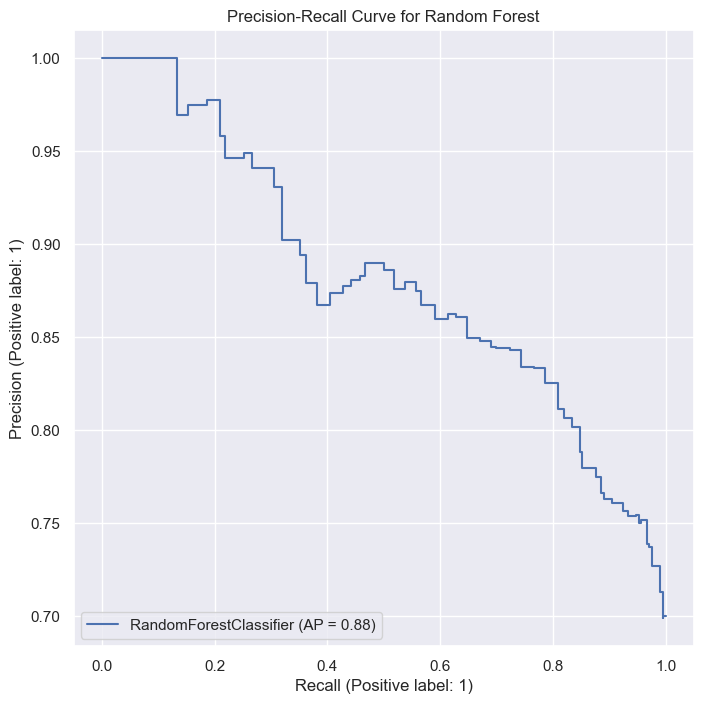

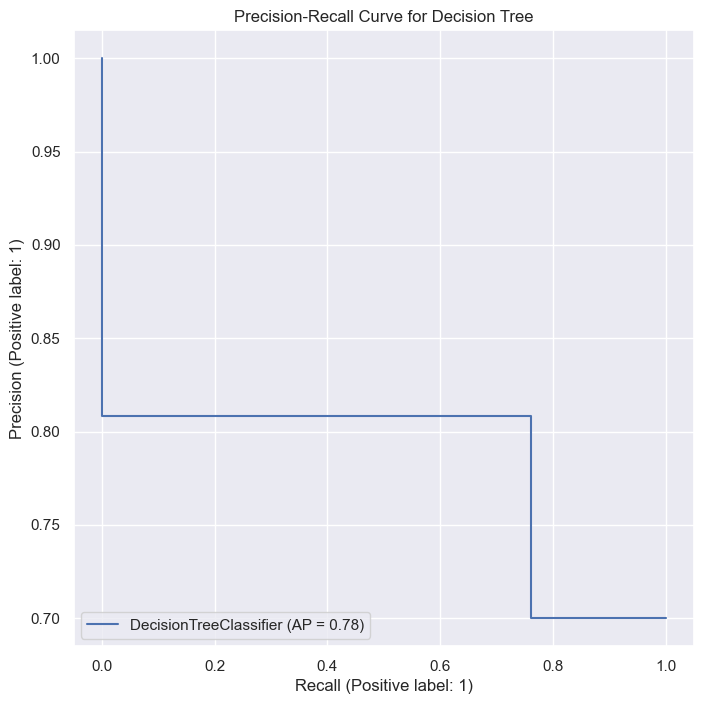

In [82]:
PrecisionRecallDisplay.from_estimator(xgb, X_test, y_test)
plt.title('Precision-Recall Curve for XGBoost')
PrecisionRecallDisplay.from_estimator(rf, X_test, y_test)
plt.title('Precision-Recall Curve for Random Forest')
PrecisionRecallDisplay.from_estimator(dt, X_test, y_test)
plt.title('Precision-Recall Curve for Decision Tree')
plt.show()

Plots above show really well the relationship between recall and precision - as recall rises, precision falls. We can also see the area under the curve (AP). XGBoost has the best result = 0.89.

<h2>Aggressive optimalization<h2/>

As XGBoost performs best in terms of the chosen metrics, I decided to try to optimize it.

In [88]:
params = {

    "learning_rate": [0.1, 0.15, 0.01, 0.075],
    "max_depth": range(6, 14, 2),
    'min_child_weight': [ 5, 6, 7, 10, 15], 
    'n_estimators' : range(160,220, 10),
    'colsample_bylevel': [0.5, 1],
    'subsample': [0.5, 0.75, 1]
}

In [89]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)
fbeta_scorer = make_scorer(fbeta_score, beta=0.5)

grid = GridSearchCV(estimator=xgb, param_grid=params, scoring=fbeta_scorer, cv=skf)
grid.f = grid.fit(X_train, y_train)

In [90]:
grid.f.best_score_

0.8206514528815957

In [91]:
grid.f.best_params_

{'colsample_bylevel': 1,
 'learning_rate': 0.15,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 210,
 'subsample': 0.75}

In [92]:
#fitting the model with best parameters
xgb_tuned = XGBClassifier(eval_metric='error', subsample=0.75,random_state=random_state, eta=0.15, max_depth=10, min_child_weight=5, n_estimators=210, colsample_bylevel=1)

In [93]:
xgb_tuned = xgb_tuned.fit(X_train, y_train)

In [94]:
y_pred_xgb_tuned = xgb_tuned.predict(X_test)

In [95]:
fbeta_xgb = fbeta_score(y_test, y_pred_xgb_tuned, beta=0.5)
fbeta_xgb

0.8141592920353983

F-beta score for the tuned XGBoost is actually worse than for the default one (XGBoost f-beta 0.8180987202925045).   
In the future, as project development, I will try to optimize it better.

<h2>Conclusion<h2/>

I have compared a few classification models: Dummy Classifier, Logistic Regression, Decision Tree, Random Forest, XGBoost, KNN and SVM. I decided to choose metrics that are well fitted to the problem of imbalanced classes (here the ratio is 30:70), that is f-beta score and Precision-Recall curve.   
   
The model that has outperformed the rest is XGBoost. It has the highest f-beta score suggesting the best relationship between precision and recall. It's supremacy is not that strange, as XGBoost is a model that in general copes well with tabular data.   

It is worth mentioning that the model with the lowest false positive rate (which was in the beginning specified as our aim) has not been chosen. Decision tree had less false positives (by 4), however it handled classifying of true positives much worse (difference by almost 20). That's why I decided to choose XGBoost as the best model, but of course if an enterprise were to implement this model, it would be important to discuss this matter with company's representatives.